# 딥러닝 CNN 모델을 이용한 폐렴 진단

본 자료 코드는 캐글 노트북 Chest X-Ray Images이며 중국 광저우에 있는 광저우 여성 및 어린이 병원의 1~5 세 소아 환자의 흉부 X선 영상을 사용함.

### 루브릭

- 모델 학습이 안정적으로 수렴하는 것을 시각화를 통해 확인하였다.


- regularization, augmentation 등의 기법의 사용 여부에 따른 모델 성능 측정이 ablation study 형태로 체계적으로 수행되었다.


- Accuracy 기준 85%에 도달하였다.

#### 의료 영상 이미지 처리에 대한 특징

- 의료 영상 이미지는 개인 정보 보호 등의 이슈로 인해 데이터를 구하는 것이 쉽지 않음

- 라벨링 작업 자체가 전문적 지식을 요하므로 데이터셋 구축 비용이 비쌈.

- 희귀질병을 다루는 경우 데이터를 입수하는 것 자체가 드뭄

- 음성/양성 데이터 간 imbalance가 심함 따라서, 학습에 주의가 필요

- 이미지만으로 진단이 쉽지 않아 다른 데이터와 결합해서 해석해야 할 수도 있음


## 라이브러리 import

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

## 데이터 준비하기

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 25

print(ROOT_PATH)

/aiffel/aiffel


In [3]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


train 안에는 5216개, test 안에는 624개, val 안에는 16개가 있으며, validation set이 전체의 0.3%로 현저히 적으므로 train 데이터를 끌어왔음

In [4]:
# train 데이터와 validation 데이터를 모두 filenames에 담음
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눔.
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


train은 4185개, test는 624개, val은 1047개가 됨. test_size를 수정하면 더 늘릴 수 있음

본 프로젝트는 train, test, validation set파일을 별개로 만들고, 사전에 정상과 폐렴을 구분하여 저장함.

In [5]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-1317-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person299_bacteria_1418.jpeg


In [6]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


결과를 보면 정상보다 폐렴 이미지 수가 3배 더 많이 있음. 

CNN 모델의 경우 데이터가 클래스별 balance가 좋을수록 training을 잘 함.

test와 val 데이터셋은 평가하기 위해서 사용되기 때문에 학습과 관련이 없으므로 imbalance한 데이터 셋이어도 문제없음.

 tf.data는 tensorflow에서 학습시킬 때, mini-batch로 작업할 수 있도록 해 줌

In [7]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [8]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [9]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있음
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

이미지 데이터는 현실적으로 사이즈가 제각각일 가능성이 높음
이미지의 사이즈를 통일 시키고 GPU 메모리를 더욱 효율적으로 사용하기 위해 이미지 사이즈를 줄이는 작업이 필요함.

process_path 함수에서 decode_img 함수를 이용해서 이미지의 데이터 타입을 float, 사이즈를 변경하고, get_label을 이용해서 라벨 값을 가져옴.

In [10]:
# 이미지를 알맞은 형식으로 바꿈.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옴.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

### train 데이터 셋과 validation 데이터 셋을 형성


num_parallel_calls 파라미터에 위에서 할당한 AUTOTUNE변수를 이용하면 더욱 빠르게 데이터를 처리해 줄 수 있음.

In [11]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

이미지가 잘 리사이즈 되었는지, 그리고 라벨이 잘 들어가 있는지 확인

In [12]:
for image, label in train_ds.take(1): 
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())
    
#코드에서 train_ds.take(1)은 하나의 데이터만 가져온다는 의미

Image shape:  (180, 180, 3)
Label:  False


### test 데이터셋 형성

In [13]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


prepare_for_training() 함수를 정의해서 데이터를 변환시켜줌.

shuffle()을 사용하며 고정 크기 버퍼를 유지하고 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택함

repeat()를 사용하면 epoch를 진행하면서 여러 번 데이터셋을 불러오게 되는데, 이때 repeat()를 사용한 데이터셋의 경우 여러 번 데이터셋을 사용할 수 있게 해줌..
예를 들어, 100개의 데이터를 10번 반복하면 1000개의 데이터가 필요하게 되는데repeat()를 사용하면 자동으로 데이터를 맞춰줌.

prefetch()를 사용하면 학습 데이터를 나눠서 읽어오기 때문에, 첫 번째 데이터를 GPU에서 학습하는 동안 두 번째 데이터를 CPU에서 준비할 수 있어 리소스의 유휴 상태를 줄일 수 있음.

## 데이터 시각화

In [14]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

 augmentation은 특히, X-RAY 같은 의료 영상의 특성상, 육안으로도 구분하기 어려운 미묘한 차이에 더해진 노이즈 등 부수효과가 오히려 방해를 줄 수도 있기 때문에 augmentation의 도입은 신중해야하며, 좌우 반전 정도의 augmentation만 도입할려고 함.

In [15]:
# def augment(image,label):
#     image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
#     return image,label

# def prepare_for_training(ds, shuffle_buffer_size=1000):
#     # augment 적용 부분이 배치처리 함수에 추가되었습니다.
#     ds = ds.map(
#             augment,       # augment 함수 적용
#             num_parallel_calls=2
#         )
#     ds = ds.shuffle(buffer_size=shuffle_buffer_size)
#     ds = ds.repeat()
#     ds = ds.batch(BATCH_SIZE)
#     ds = ds.prefetch(buffer_size=AUTOTUNE)

#     return ds

# train_ds = prepare_for_training(train_ds)
# val_ds = prepare_for_training(val_ds)

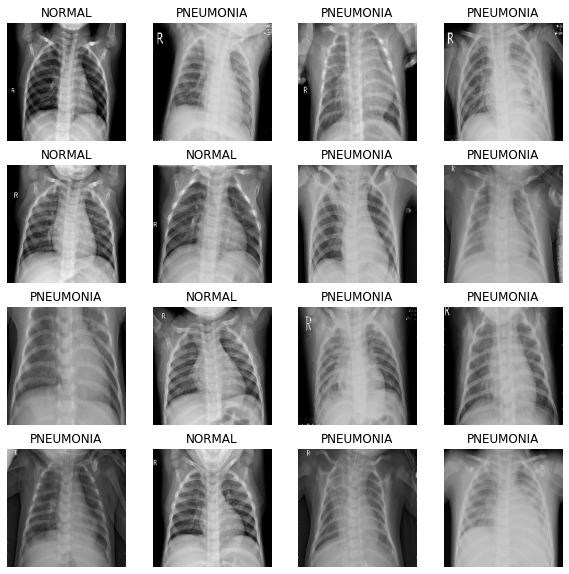

In [16]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

## CNN 모델링 설계

기존 CNN과 다르게 Batch Normalization과 Dropout이라는 두 가지 regularization 기법이 동시에 사용함.


In [17]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [18]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [19]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model


### 데이터 imbalance 처리

- Weight balancing : training set의 각 데이터에서 loss를 계산할 때 특정 클래스의 데이터에 더 큰 loss 값을 갖도록 가중치를 부여하는 방법(원하는 클래스의 데이터의 loss 에는 특정 값을 곱하고, 이를 통해 딥러닝 모델을 트레이닝하는 것)
    ->클래스 불균형이 있는 경우, 클래스에 따라 정확도가 달라지게 됨.


- Keras는 model.fit()을 호출할 때 파라미터로 넘기는 class_weight 에 이러한 클래스별 가중치를 세팅할 수 있도록 지원하고 있음.

weight_for_0은 'Normal' 이미지에 사용할 weight를, 
weight_for_1은 'Pneumonia' 이미지에 사용할 weight를 세팅함. 
이 weight들은 'Normal'과 'Pneumonia' 전체 데이터 건수에 반비례하도록 설정함

In [20]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


## 모델 훈련

이미지 훈련은 GPU를 통해 진행하며, 이미지의 라벨이 두 개밖에 없기 때문에 "binary_cross entropy" loss를 사용함.

In [21]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [22]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 62s 190ms/step - loss: 0.3651 - accuracy: 0.8211 - precision: 0.9595 - recall: 0.7929 - val_loss: 0.8068 - val_accuracy: 0.7385 - val_precision: 0.7385 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 49s 188ms/step - loss: 0.2309 - accuracy: 0.9174 - precision: 0.9730 - recall: 0.9144 - val_loss: 1.3702 - val_accuracy: 0.7375 - val_precision: 0.7375 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 49s 190ms/step - loss: 0.2117 - accuracy: 0.9136 - precision: 0.9761 - recall: 0.9060 - val_loss: 0.4615 - val_accuracy: 0.7913 - val_precision: 0.7790 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 50s 193ms/step - loss: 0.1929 - accuracy: 0.9243 - precision: 0.9787 - recall: 0.9182 - val_loss: 0.3951 - val_accuracy: 0.8827 - val_precision: 0.9984 - val_recall: 0.8418
Epoch 5/25
261/261 [==============================] - 51s 198ms/step - loss: 0.1591 - accura

## 모델 평가

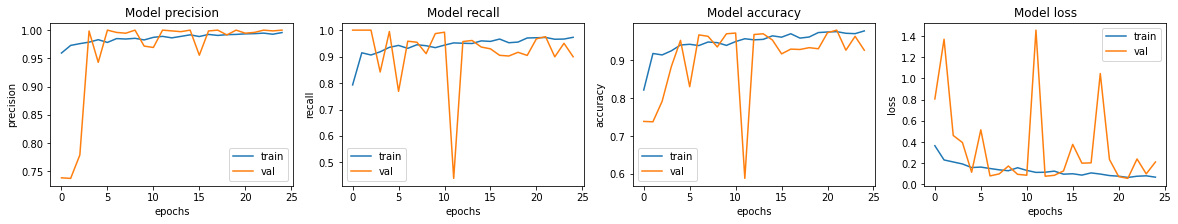

In [23]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [24]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 110ms/step - loss: 0.7181 - accuracy: 0.8686 - precision: 0.8720 - recall: 0.9256
Loss: 0.7180607914924622,
Accuracy: 0.8685897588729858,
Precision: 0.8719806671142578,
Recall: 0.9256410002708435


### 알게 된 점
- batch size : 데이터를 학습하는 과정에서 최적화(Gradient descent) 할 때 한번에 몇개의 데이터를 가지고 하는 지를 나타냄. 데이터가 엄청나게 많은 경우 전체데이터를 보고 최적화를 할 때 엄청난 시간이 할애할 수 있으며, 정확도가 떨어지긴 하지만 위 사이즈를 줄여서 시간을 단축시킬 수 있음.



- SGD ( Stochastic Gradient Descent ) : 확률적 경사 하강법 : 하나의 Training data ( Batch size = 1 ) 마다 Cost 를 계산하고 바로 Gradient descent를 적용하여 weight 를 빠르게 update. 
ex) 100개의 문제가 주어졌다고 했을 때, 문제를 하나 푸고 정답보고 정답률 향상시키고, 또다시 다른 문제를 풀고 정답보고 향상 시키는 식으로 하.나.하나.씩 진행함.

 -> 한개의 Training data 마다 매번 weight 를 갱신하기 때문에 신경망의 성능이 들쑥날쑥 변함( Cost 값이 안정적으로 줄어들지 않음 )

 -> 최적의 Learning rate 를 구하기 위해 일일이 튜닝하고 수렴 조건 ( early - Stop ) 을 조정해야함. 
 
 -> 즉, 시간만 봤을 때는 최고의 효율을 뽑아내지만, 정확도 측면을 고려하면 데이터 확인을 적게하기 때문에 그만큼 정밀한 정확도를 얻기 힘듬.
 
 
- Mini-batch : Training data 에서 일정한 크기 ( == Batch size ) 의 데이터를 선택하여 Cost function 계산 및 Gradient descent 적용
ex) 100개의 문제중 10개의 문제를 보고 답안지를 보고 정답률을 향상시키고, 또 다시 10개의 문제를 보고 정답률을 향상시킴.(Batch size ==10 일 경우)
    -> full batch 및 SGD의 단점을 극복하였으며,설계자의 의도에 따라 속도와 안정성을 동시에 관리할 수 있으며, GPU 기반의 효율적인 병렬 연산이 가능함.
    

- Full-batch : mini-batch랑 다르게 모든 문제를 다 풀고 정답을 확인하고 정답률을 증가 시킴 (Batch size == 100 )

- 의료데이터의 경우 구하기가 어렵고 구하더라도 데이터가 적은 경우가 많음.이때, 기본적인 Data augmentation방법을 많이 사용함.(회전, 가우시안 노이즈 추가 방법 등을 많이 사용) but, 특히 X-RAY 같은 의료 영상의 특성상, 육안으로도 구분하기 어려운 미묘한 차이에 더해진 노이즈 등 부수효과가 오히려 방해를 줄 수도 있음

- Dropout : 신경망에서 과대적합을 줄이는 방법으로서,무작위로 일부 뉴런을 비활성화시킴. 무작위로 일부 뉴런을 비활성화시키면 특정 뉴런에 과도하게 의존하여 훈련하는 것을 막아주는데, 일부 뉴런이 비활성화 되었을 때도 타깃을 잘 예측하기 위해 특정 뉴런에 과도하게 의존하지 않고 모든 뉴런이 의미있는 패턴을 학습을 하게 되고 결과적으로 전체적인 일반화 성능이 높아짐


## Report

- 변형된 CNN 모델을 사용하여 폐렴 이미지 판독의 정확률을 높이고자 함. 처음 이미지 판독시 84%의 정확성을 보였음.


- 정확성을 개선시키기 위하여, Data augmentation방법을 추가하였고, 데이터의 양을 생각하였을 때, 손실값과, optimizer의 수정보다는 learning rate의 수정과 regulirization이 필요하다고 판단함.
    -> augmentation방법을 단독으로 추가하였을 때, accuracy는 84에서 77%로 떨어짐을 확인함.
    -> sequential CNN model을 기존 모델로 바꾸어 보았으나, 계속 에러가 포기함.


- 기존 프로젝트에서 제시하기로는, Batch Normalization과 Dropout이라는 두 가지 regularization 기법이 동시에 사용한 이유가, 이미지 사이즈가 크고, 데이터가 부족한 의료 영상에서는 실용적으로 간혹 좋은 성능을 보이기 때문에 적용했다고는 하지만, 이미지 사이즈가 클때는 nomalirization 부분을 적용하면되지, 왜 굳이 drop out을 적용해야되는지 합당한 근거를 모색하고 했음.
    -> drop out을 제거하였을 때 오히려, precision 값 및 recall 값이 저하됨을 확인함.
    

- 데이터양에 비해 batch size가 작다고 판단되어 100으로 올리며, epoch값을 20회로 변경해봄
     -> batch-size가 현저하게 증가되어서 그런지 precision값이 60%대로 떨어짐.


- 결론적으로, 대략 86% 정도의 정확도를 가진 X-RAY 사진 판독 폐렴진단기가 만들어졌으며, 그래프를 확인하였을 때 validation set에서 epochs 10쯤 됬을 때, 값 변동이 큰 것을 확인함 (recall, accuracy, loss)

#### 참고 사이트

- Mini-batch : https://acdongpgm.tistory.com/202
- Weight balancing : https://3months.tistory.com/414 [Deep Play]
- CNN : http://taewan.kim/post/cnn/